Baseline Model Accuracy: 0.7827715355805244
Baseline Model Confusion Matrix:
 [[143  23]
 [ 35  66]]
Baseline Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       166
           1       0.74      0.65      0.69       101

    accuracy                           0.78       267
   macro avg       0.77      0.76      0.76       267
weighted avg       0.78      0.78      0.78       267

Mitigated Model Accuracy: 0.700374531835206
Mitigated Model Confusion Matrix:
 [[152  14]
 [ 66  35]]
Mitigated Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.79       166
           1       0.71      0.35      0.47       101

    accuracy                           0.70       267
   macro avg       0.71      0.63      0.63       267
weighted avg       0.70      0.70      0.67       267



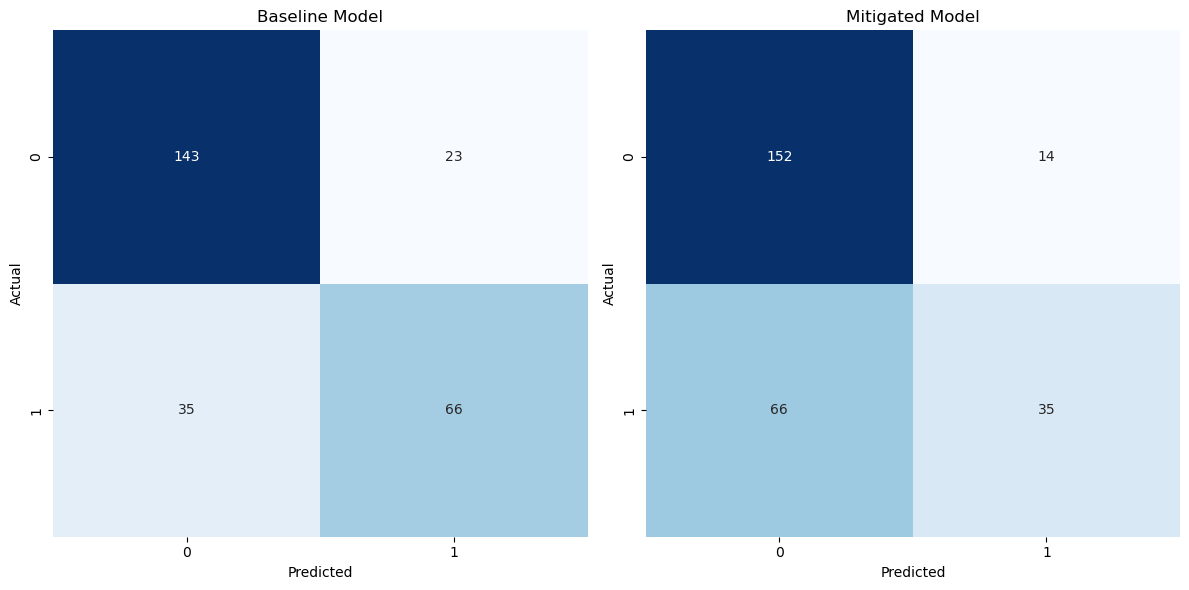

Baseline Fairness Metrics: {'demographic_parity_difference': 0.539749505603164, 'equalized_odds_difference': 0.3738262910798122}
Mitigated Fairness Metrics: {'demographic_parity_difference': 0.08714568226763347, 'equalized_odds_difference': 0.206495589414595}


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
import matplotlib.pyplot as plt
import seaborn as sns

# Load Titanic dataset
url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
df = pd.read_csv(url)

# Select and preprocess columns
df = df[['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare', 'Survived']]
df = df.dropna()  # Drop rows with missing values

# Encode categorical variables
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Define features and target
X = df[['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']]
y = df['Survived']

# Introduce synthetic bias (separate variable for sensitive feature)
X['Bias'] = np.where(X['Sex'] == 1, 0.1, 0.0)  # Adding bias to female entries

# Standardize numerical features
scaler = StandardScaler()
X[['Age', 'Fare']] = scaler.fit_transform(X[['Age', 'Fare']])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate baseline model
y_pred = model.predict(X_test)
print("Baseline Model Accuracy:", accuracy_score(y_test, y_pred))
print("Baseline Model Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Baseline Classification Report:\n", classification_report(y_test, y_pred))

# Fairlearn setup for mitigating bias
mitigator = ExponentiatedGradient(
    estimator=model,
    constraints=DemographicParity()
)

# Fit the mitigator
mitigator.fit(X_train, y_train, sensitive_features=X_train['Bias'])

# Predict with mitigated model
y_pred_mitigated = mitigator.predict(X_test)
print("Mitigated Model Accuracy:", accuracy_score(y_test, y_pred_mitigated))
print("Mitigated Model Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mitigated))
print("Mitigated Classification Report:\n", classification_report(y_test, y_pred_mitigated))

# Plot confusion matrices
def plot_confusion_matrices(cm1, cm2, labels):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title('Baseline Model')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)
    axes[1].set_title('Mitigated Model')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(confusion_matrix(y_test, y_pred), confusion_matrix(y_test, y_pred_mitigated), labels=['0', '1'])

# Define fairness metrics
def compute_fairness_metrics(y_true, y_pred, sensitive_features):
    return {
        'demographic_parity_difference': demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features),
        'equalized_odds_difference': equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    }

# Compute fairness metrics for both models
fairness_baseline = compute_fairness_metrics(y_test, y_pred, X_test['Bias'])
fairness_mitigated = compute_fairness_metrics(y_test, y_pred_mitigated, X_test['Bias'])

print("Baseline Fairness Metrics:", fairness_baseline)
print("Mitigated Fairness Metrics:", fairness_mitigated)
